In [5]:
# If needed, uncomment to install deps
# !pip install -q transformers timm tifffile

import os
import re
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import tifffile as tiff
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import SegformerForSemanticSegmentation

# Colab: mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
import zipfile
import os

# Path to your zip file
zip_path = "/content/drive/MyDrive/Dataset/Dataset.zip"
extract_dir = "/content/Dataset"   # where you want to unzip

# Make sure output dir exists
os.makedirs(extract_dir, exist_ok=True)

# Extract zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"✅ Dataset extracted to: {extract_dir}")

# Paths after extraction
images_path = os.path.join(extract_dir, "Dataset", "Images")
masks_path  = os.path.join(extract_dir, "Dataset", "Mask")

# Quick check
print("\nSample files:")
print("Images:", os.listdir(images_path)[:5])
print("Masks:", os.listdir(masks_path)[:5])


✅ Dataset extracted to: /content/Dataset

Sample files:
Images: ['Image_188.tif', 'Image_093.tif', 'Image_153.tif', 'Image_193.tif', 'Image_203.tif']
Masks: ['Mask_078.tif', 'Mask_125.tif', 'Mask_182.tif', 'Mask_168.tif', 'Mask_029.tif']


In [7]:
# ================================
# Dataset Definition (with Albumentations support)
# ================================
import os, numpy as np, torch
from torch.utils.data import Dataset
from PIL import Image
import tifffile as tiff

class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, image_size=512, num_classes=4, normalize=True, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_size = image_size
        self.num_classes = num_classes
        self.normalize = normalize
        self.transform = transform   #  Albumentations pipeline (if provided)

        # File lists
        self.image_files = sorted([f for f in os.listdir(images_dir) if f.lower().endswith(('.tif','.tiff','.png','.jpg','.jpeg'))])
        self.mask_files  = sorted([f for f in os.listdir(masks_dir)  if f.lower().endswith(('.tif','.tiff','.png','.jpg','.jpeg'))])

        assert len(self.image_files) == len(self.mask_files), "❌ Images and masks count mismatch!"

        # Normalization stats (ImageNet)
        self.mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
        self.std  = np.array([0.229, 0.224, 0.225], dtype=np.float32)

    def _read_image(self, path):
        if path.lower().endswith(('.tif','.tiff')):
            arr = tiff.imread(path)
        else:
            arr = np.array(Image.open(path))

        arr = np.squeeze(arr)
        if arr.dtype != np.uint8:
            arr = (255 * (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)).astype(np.uint8)
        if arr.ndim == 2:
            arr = np.stack([arr]*3, axis=-1)  # grayscale → RGB
        return arr

    def _read_mask(self, path):
        if path.lower().endswith(('.tif','.tiff')):
            arr = tiff.imread(path)
        else:
            arr = np.array(Image.open(path))
        arr = np.squeeze(arr)
        if arr.ndim == 3:
            arr = arr[:, :, 0]  # take first channel if 3D
        return arr

    def __getitem__(self, idx):
        img_path  = os.path.join(self.images_dir, self.image_files[idx])
        mask_path = os.path.join(self.masks_dir,  self.mask_files[idx])

        img = self._read_image(img_path)
        mask = self._read_mask(mask_path)

        #  Apply Albumentations if provided
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img, mask = augmented["image"], augmented["mask"]
        else:
            # Default resizing
            img = Image.fromarray(img).resize((self.image_size, self.image_size), resample=Image.BILINEAR)
            mask = Image.fromarray(mask).resize((self.image_size, self.image_size), resample=Image.NEAREST)

            img = np.array(img, dtype=np.float32) / 255.0
            mask = np.array(mask, dtype=np.int64)

            # Normalize
            if self.normalize:
                img = (img - self.mean) / self.std

            # To tensor
            img = np.transpose(img, (2, 0, 1))  # C,H,W
            img = torch.tensor(img, dtype=torch.float32)
            mask = torch.tensor(mask, dtype=torch.long)

        # Ensure mask class indices are valid
        mask[mask >= self.num_classes] = self.num_classes - 1

        return img, mask

    def __len__(self):
        return len(self.image_files)


# ================================
# Step 1: Quick Dataset Check
# ================================
IMAGES_DIR = "/content/Dataset/Dataset/Images"
MASKS_DIR  = "/content/Dataset/Dataset/Mask"

full_dataset = SegmentationDataset(IMAGES_DIR, MASKS_DIR, image_size=512, num_classes=5, normalize=True)

print("✅ Dataset loaded!")
print("Total samples:", len(full_dataset))

x, y = full_dataset[0]
print("Image shape:", x.shape)   # expect [3,512,512]
print("Mask shape:", y.shape)    # expect [512,512]


✅ Dataset loaded!
Total samples: 232
Image shape: torch.Size([3, 512, 512])
Mask shape: torch.Size([512, 512])


In [8]:
# ================================
# Step 2: Train/Val Split + Loader
# ================================
from torch.utils.data import random_split, DataLoader

train_size = int(0.8 * len(full_dataset))
val_size   = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

BATCH_SIZE = 4
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")

xb, yb = next(iter(train_loader))
print("Batch shapes -> images:", tuple(xb.shape), "masks:", tuple(yb.shape))  # [B,3,512,512], [B,512,512]


Train samples: 185, Val samples: 47
Batch shapes -> images: (4, 3, 512, 512) masks: (4, 512, 512)


cheching the sequence

In [9]:
pip install albumentations


In [10]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomRotate90(p=0.5),
    # A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=25,
                      #  border_mode=0, interpolation=1, p=0.7),  # interpolation=1 = NEAREST
    # A.RandomBrightnessContrast(p=0.5),
    # A.GaussianBlur(p=0.3),
    # A.ElasticTransform(p=0.2),
])


In [11]:
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, image_size=512, num_classes=4, normalize=True, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_files = sorted([f for f in os.listdir(images_dir) if f.lower().endswith(('.tif','.tiff','.png','.jpg','.jpeg'))])
        self.mask_files  = sorted([f for f in os.listdir(masks_dir)  if f.lower().endswith(('.tif','.tiff','.png','.jpg','.jpeg'))])
        assert len(self.image_files) == len(self.mask_files), f"Images({len(self.image_files)}) != Masks({len(self.mask_files)})"

        self.image_size = image_size
        self.num_classes = num_classes
        self.normalize = normalize
        self.transform = transform

        # ImageNet normalization
        self.mean = np.array([0.485, 0.456, 0.406], dtype=np.float32).reshape(3,1,1)
        self.std  = np.array([0.229, 0.224, 0.225], dtype=np.float32).reshape(3,1,1)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path  = os.path.join(self.images_dir, self.image_files[idx])
        mask_path = os.path.join(self.masks_dir,  self.mask_files[idx])

        try:
            # ---- Image ----
            img = np.array(Image.open(img_path).convert("RGB"))
            mask = np.array(Image.open(mask_path))

            # Resize
            img = np.array(Image.fromarray(img).resize((self.image_size, self.image_size), resample=Image.BILINEAR))
            mask = np.array(Image.fromarray(mask).resize((self.image_size, self.image_size), resample=Image.NEAREST))

            #  Apply augmentation
            if self.transform is not None:
                augmented = self.transform(image=img, mask=mask)
                img, mask = augmented["image"], augmented["mask"]
            else:
                img = np.transpose(img, (2,0,1)).astype(np.float32) / 255.0
                if self.normalize:
                    img = (img - self.mean) / self.std
                img = torch.tensor(img, dtype=torch.float32)

            # Ensure mask class IDs
            mask = torch.tensor(mask, dtype=torch.long)
            mask[mask >= self.num_classes] = self.num_classes - 1

            return img, mask
        except Exception as e:
            print(f"Warning: Skipping image {img_path} due to error: {e}")
            return self.__getitem__((idx + 1) % len(self)) # Recursively call for next image

In [12]:
import torch
import torch.nn as nn

class AttentionUpsample(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()

        # --- Learnable upsampling instead of bilinear ---
        self.up = nn.ConvTranspose2d(
            in_channels, in_channels, kernel_size=2, stride=2
        )

        # Project input and skip connections to same channels
        self.conv_in = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.conv_skip = nn.Conv2d(skip_channels, out_channels, kernel_size=1)

        # Attention map
        self.attn = nn.Sequential(
            nn.Conv2d(out_channels * 2, out_channels, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, 1, kernel_size=1),
            nn.Sigmoid()
        )

        # Final refinement
        self.conv_out = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x, skip):
        # 1. Upsample using ConvTranspose2d
        x = self.up(x)

        # 2. If size mismatch (odd dims), force match
        if x.shape[-2:] != skip.shape[-2:]:
            x = nn.functional.interpolate(x, size=skip.shape[2:], mode="nearest")

        # 3. Project features
        x_proj = self.conv_in(x)
        skip_proj = self.conv_skip(skip)

        # 4. Compute attention mask
        attn_map = self.attn(torch.cat([x_proj, skip_proj], dim=1))

        # 5. Weighted fusion
        out = attn_map * x_proj + (1 - attn_map) * skip_proj
        out = self.conv_out(out)
        return out


In [13]:
import torch
import torch.nn as nn
from transformers import SegformerModel

class CustomSegFormer(nn.Module):
    def __init__(self, num_classes=5, id2label=None, label2id=None):
        super(CustomSegFormer, self).__init__()

        # === Encoder (pretrained SegFormer B2) ===
        self.encoder = SegformerModel.from_pretrained(
            "nvidia/segformer-b2-finetuned-ade-512-512",
            output_hidden_states=True
        )

        # SegFormer B2 hidden sizes
        embed_dim = [64, 128, 320, 512]
        decoder_dim = 512

        # Projections
        self.linear_c4 = nn.Conv2d(embed_dim[3], decoder_dim, kernel_size=1)
        self.linear_c3 = nn.Conv2d(embed_dim[2], decoder_dim, kernel_size=1)
        self.linear_c2 = nn.Conv2d(embed_dim[1], decoder_dim, kernel_size=1)
        self.linear_c1 = nn.Conv2d(embed_dim[0], decoder_dim, kernel_size=1)

        # Attention-guided upsampling blocks
        self.agu3 = AttentionUpsample(decoder_dim, decoder_dim, decoder_dim)
        self.agu2 = AttentionUpsample(decoder_dim, decoder_dim, decoder_dim)
        self.agu1 = AttentionUpsample(decoder_dim, decoder_dim, decoder_dim)

        # Final classifier
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Conv2d(decoder_dim, num_classes, kernel_size=1)

    def forward(self, pixel_values):
        # === Encoder ===
        outputs = self.encoder(pixel_values)
        c1, c2, c3, c4 = outputs.hidden_states  # already (B, C, H, W)

        # Project to same decoder_dim
        c1, c2, c3, c4 = self.linear_c1(c1), self.linear_c2(c2), self.linear_c3(c3), self.linear_c4(c4)

        # === Decoder with AGU ===
        x = self.agu3(c4, c3)  # fuse high-level with C3
        x = self.agu2(x, c2)   # fuse with C2
        x = self.agu1(x, c1)   # fuse with C1

        # Final head
        x = self.dropout(x)
        logits = self.classifier(x)

        # Restore to original image size
        logits = nn.functional.interpolate(logits, size=pixel_values.shape[2:], mode="bilinear", align_corners=False)

        return logits


In [14]:
# === Usage ===
id2label = {0: "Shadow", 1: "Urban", 2: "Water", 3: "Vegetation",4: "Others"}
label2id = {v: k for k, v in id2label.items()}

model = CustomSegFormer(num_classes=5, id2label=id2label, label2id=label2id)
# print(model)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/110M [00:00<?, ?B/s]

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# id2label = {0:"Urban", 1:"Water", 2:"Vegetation", 3:"Others"}
# label2id = {v:k for k,v in id2label.items()}

# model = SegformerForSemanticSegmentation.from_pretrained(
#     "nvidia/segformer-b0-finetuned-ade-512-512",
#     num_labels=4,
#     id2label=id2label,
#     label2id=label2id,
#     ignore_mismatched_sizes=True,  # new head (4 classes) initialized
# )
model.to(device)

# Optim & training settings
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)
num_epochs = 50


to check augmentation

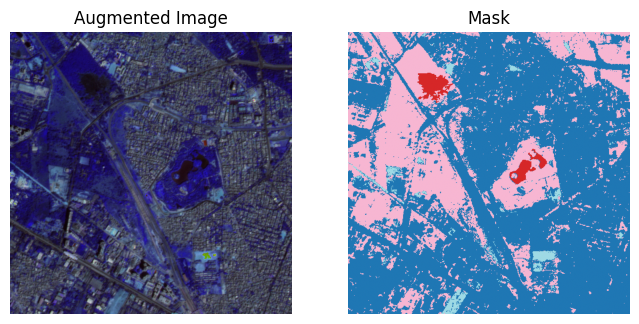

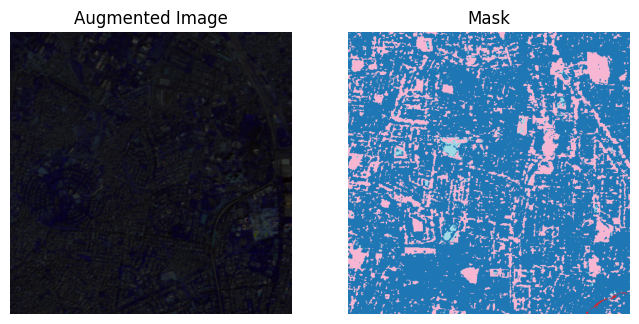

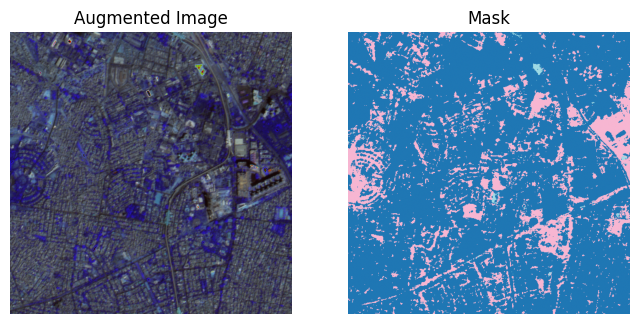

In [16]:
import matplotlib.pyplot as plt

# Take random samples from training dataset
for i in range(3):
    img, mask = train_dataset[np.random.randint(len(train_dataset))]

    # Convert image tensor to numpy
    img_np = img.numpy().transpose(1,2,0)  # [H,W,C]

    # Undo normalization if applied
    img_np = (img_np * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    img_np = np.clip(img_np, 0, 1)

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.imshow(img_np); plt.title("Augmented Image"); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(mask.numpy(), cmap="tab20"); plt.title("Mask"); plt.axis("off")
    plt.show()


In [17]:
def pixel_accuracy(preds, labels):
    # preds: [B,H,W] (class ids), labels: [B,H,W]
    correct = (preds == labels).sum().item()
    total = labels.numel()
    return correct / total

def mean_iou(preds, labels, num_classes=4):
    # preds, labels: [B,H,W]
    ious = []
    for cls in range(num_classes):
        pred_c = (preds == cls)
        label_c = (labels == cls)
        inter = (pred_c & label_c).sum().item()
        union = (pred_c | label_c).sum().item()
        if union == 0:
            ious.append(float("nan"))  # ignore if class not present in both
        else:
            ious.append(inter / union)
    return np.nanmean(ious)


In [18]:
print(f"Train samples: {len(train_dataset)} ({len(train_loader)} batches of size {BATCH_SIZE})")
print(f"Val samples:   {len(val_dataset)} ({len(val_loader)} batches of size {BATCH_SIZE})")


Train samples: 185 (47 batches of size 4)
Val samples:   47 (12 batches of size 4)


New loss funtion: CE+Lovasz

In [19]:
import torch
import torch.nn.functional as F

# ==============================
# Lovasz Loss Implementation
# ==============================

def lovasz_grad(gt_sorted):
    """Computes gradient of the Lovasz extension w.r.t sorted errors."""
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if gt_sorted.numel() > 1:
        jaccard[1:] = jaccard[1:] - jaccard[:-1]
    return jaccard

def lovasz_softmax(probs, labels, classes='present', per_image=False, ignore=None):
    """
    probs: [B, C, H, W] class probabilities at each prediction (after softmax)
    labels: [B, H, W] ground truth labels
    classes: 'all' or 'present' — which classes to average
    per_image: compute per-image instead of per-batch
    ignore: label to ignore
    """
    if per_image:
        loss = torch.mean(torch.stack([
            lovasz_softmax_flat(*flatten_probas(prob.unsqueeze(0), lab.unsqueeze(0), ignore), classes=classes)
            for prob, lab in zip(probs, labels)
        ]))
    else:
        loss = lovasz_softmax_flat(*flatten_probas(probs, labels, ignore), classes=classes)
    return loss

def lovasz_softmax_flat(probs, labels, classes='present'):
    if probs.numel() == 0:
        return probs * 0.
    C = probs.size(1)
    losses = []
    class_to_sum = list(range(C)) if classes in ['all', 'present'] else classes
    for c in class_to_sum:
        fg = (labels == c).float()  # foreground for class c
        if classes == 'present' and fg.sum() == 0:
            continue
        errors = (fg - probs[:, c]).abs()
        errors_sorted, perm = torch.sort(errors, descending=True)
        fg_sorted = fg[perm]
        grad = lovasz_grad(fg_sorted)
        losses.append(torch.dot(errors_sorted, grad))
    return torch.mean(torch.stack(losses))

def flatten_probas(probs, labels, ignore=None):
    """Flattens predictions in the batch."""
    B, C, H, W = probs.size()
    probs = probs.permute(0,2,3,1).contiguous().view(-1, C)
    labels = labels.view(-1)
    if ignore is None:
        return probs, labels
    valid = (labels != ignore)
    vprobs = probs[valid.nonzero(as_tuple=False).squeeze()]
    vlabels = labels[valid]
    return vprobs, vlabels


In [20]:
import torch.nn as nn

class CELovaszLoss(nn.Module):
    def __init__(self, ce_ratio=0.5, ignore_index=255, weight=None):
        super(CELovaszLoss, self).__init__()
        self.ce = nn.CrossEntropyLoss(weight=weight, ignore_index=ignore_index)
        self.ce_ratio = ce_ratio
        self.ignore_index = ignore_index

    def forward(self, preds, targets):
        # Cross Entropy
        ce_loss = self.ce(preds, targets)

        # Lovasz (works with probabilities)
        probs = torch.softmax(preds, dim=1)
        lovasz_loss = lovasz_softmax(probs, targets, ignore=self.ignore_index)

        return self.ce_ratio * ce_loss + (1 - self.ce_ratio) * lovasz_loss


In [21]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []
train_ious, val_ious = [], []

# Define the loss function i.e. combination of CE and Lovasz
criterion = CELovaszLoss(ce_ratio=0.5, ignore_index=255)

for epoch in range(1, num_epochs+1):
    # ---- Train ----
    model.train()
    tr_loss, tr_acc, tr_iou = 0.0, 0.0, 0.0
    for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} - Training"):
        imgs, masks = imgs.to(device), masks.to(device)

        # out = model(pixel_values=imgs, labels=masks)   # CrossEntropy inside
        # loss = out.loss
        # logits = out.logits                            # [B, num_classes, H, W]

        logits = model(pixel_values=imgs)             # [B, num_classes, H, W]
        loss = criterion(logits, masks)               # Calculate loss manually

        preds = torch.argmax(logits, dim=1)            # [B,H,W]

        # Resize predictions to match mask size for metric calculation
        preds_resized = torch.nn.functional.interpolate(preds.unsqueeze(1).float(),
                                                        size=masks.shape[-2:],
                                                        mode='nearest').squeeze(1).long()


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss += loss.item()
        tr_acc  += pixel_accuracy(preds_resized, masks)
        tr_iou  += mean_iou(preds_resized, masks, num_classes=4)

    tr_loss /= len(train_loader)
    tr_acc  /= len(train_loader)
    tr_iou  /= len(train_loader)

    train_losses.append(tr_loss)
    train_accs.append(tr_acc)
    train_ious.append(tr_iou)

    # ---- Validate ----
    model.eval()
    va_loss, va_acc, va_iou = 0.0, 0.0, 0.0
    with torch.no_grad():
        for imgs, masks in tqdm(val_loader, desc="Validating"):
            imgs, masks = imgs.to(device), masks.to(device)
            # out = model(pixel_values=imgs, labels=masks)
            # va_loss += out.loss.item()
            logits = model(pixel_values=imgs)
            va_loss += criterion(logits, masks).item()


            # logits = out.logits  # Remove this line
            preds = torch.argmax(logits, dim=1)
            # Resize predictions to match mask size for metric calculation
            preds_resized = torch.nn.functional.interpolate(preds.unsqueeze(1).float(),
                                                            size=masks.shape[-2:],
                                                            mode='nearest').squeeze(1).long()


            va_acc += pixel_accuracy(preds_resized, masks)
            va_iou += mean_iou(preds_resized, masks, num_classes=4)

    va_loss /= len(val_loader)
    va_acc  /= len(val_loader)
    va_iou  /= len(val_loader)

    val_losses.append(va_loss)
    val_accs.append(va_acc)
    val_ious.append(va_iou)

    print(f"Epoch {epoch}/{num_epochs} | "
          f"Train Loss: {tr_loss:.4f}  Val Loss: {va_loss:.4f}  |  "
          f"Train Acc: {tr_acc*100:.2f}%  Val Acc: {va_acc*100:.2f}%  |  "
          f"Train mIoU: {tr_iou:.4f}  Val mIoU: {va_iou:.4f}")

Validating: 100%|██████████| 12/12 [00:04<00:00,  2.92it/s]


Epoch 1/50 | Train Loss: 0.8194  Val Loss: 0.6616  |  Train Acc: 62.93%  Val Acc: 70.25%  |  Train mIoU: 0.3334  Val mIoU: 0.5408


Validating: 100%|██████████| 12/12 [00:03<00:00,  3.81it/s]


Epoch 2/50 | Train Loss: 0.6642  Val Loss: 0.6382  |  Train Acc: 70.70%  Val Acc: 71.55%  |  Train mIoU: 0.4869  Val mIoU: 0.5458


Validating: 100%|██████████| 12/12 [00:03<00:00,  3.76it/s]


Epoch 3/50 | Train Loss: 0.6381  Val Loss: 0.6029  |  Train Acc: 71.61%  Val Acc: 72.26%  |  Train mIoU: 0.5109  Val mIoU: 0.5672


Validating: 100%|██████████| 12/12 [00:03<00:00,  3.64it/s]


Epoch 4/50 | Train Loss: 0.6063  Val Loss: 0.5885  |  Train Acc: 72.46%  Val Acc: 72.48%  |  Train mIoU: 0.5394  Val mIoU: 0.5739


Validating: 100%|██████████| 12/12 [00:04<00:00,  2.92it/s]


Epoch 5/50 | Train Loss: 0.6082  Val Loss: 0.5686  |  Train Acc: 71.66%  Val Acc: 72.66%  |  Train mIoU: 0.5141  Val mIoU: 0.5791


Validating: 100%|██████████| 12/12 [00:03<00:00,  3.78it/s]


Epoch 6/50 | Train Loss: 0.5822  Val Loss: 0.5644  |  Train Acc: 72.47%  Val Acc: 72.82%  |  Train mIoU: 0.5228  Val mIoU: 0.5852


Validating: 100%|██████████| 12/12 [00:03<00:00,  3.74it/s]


Epoch 7/50 | Train Loss: 0.5837  Val Loss: 0.5659  |  Train Acc: 72.17%  Val Acc: 72.12%  |  Train mIoU: 0.5189  Val mIoU: 0.5692


Validating: 100%|██████████| 12/12 [00:03<00:00,  3.65it/s]


Epoch 8/50 | Train Loss: 0.5788  Val Loss: 0.5460  |  Train Acc: 72.25%  Val Acc: 73.19%  |  Train mIoU: 0.5336  Val mIoU: 0.5837


Validating: 100%|██████████| 12/12 [00:03<00:00,  3.74it/s]


Epoch 9/50 | Train Loss: 0.5526  Val Loss: 0.5509  |  Train Acc: 73.46%  Val Acc: 72.85%  |  Train mIoU: 0.5445  Val mIoU: 0.5827


Validating: 100%|██████████| 12/12 [00:03<00:00,  3.81it/s]


Epoch 10/50 | Train Loss: 0.5530  Val Loss: 0.5335  |  Train Acc: 73.85%  Val Acc: 73.77%  |  Train mIoU: 0.5467  Val mIoU: 0.5973


Validating: 100%|██████████| 12/12 [00:03<00:00,  3.71it/s]


Epoch 11/50 | Train Loss: 0.5383  Val Loss: 0.5462  |  Train Acc: 74.80%  Val Acc: 73.31%  |  Train mIoU: 0.5673  Val mIoU: 0.5915


Validating: 100%|██████████| 12/12 [00:03<00:00,  3.58it/s]


Epoch 12/50 | Train Loss: 0.5334  Val Loss: 0.5235  |  Train Acc: 75.08%  Val Acc: 74.07%  |  Train mIoU: 0.5737  Val mIoU: 0.6018


Validating: 100%|██████████| 12/12 [00:03<00:00,  3.81it/s]


Epoch 13/50 | Train Loss: 0.5307  Val Loss: 0.5390  |  Train Acc: 75.47%  Val Acc: 72.92%  |  Train mIoU: 0.5579  Val mIoU: 0.5865


Validating: 100%|██████████| 12/12 [00:03<00:00,  3.78it/s]


Epoch 14/50 | Train Loss: 0.5325  Val Loss: 0.5491  |  Train Acc: 75.54%  Val Acc: 73.25%  |  Train mIoU: 0.5657  Val mIoU: 0.5949


Validating: 100%|██████████| 12/12 [00:03<00:00,  3.78it/s]


Epoch 15/50 | Train Loss: 0.5196  Val Loss: 0.5210  |  Train Acc: 76.25%  Val Acc: 74.84%  |  Train mIoU: 0.5718  Val mIoU: 0.6084


Validating: 100%|██████████| 12/12 [00:03<00:00,  3.57it/s]


Epoch 16/50 | Train Loss: 0.5113  Val Loss: 0.5203  |  Train Acc: 76.83%  Val Acc: 74.25%  |  Train mIoU: 0.5810  Val mIoU: 0.5638


Validating: 100%|██████████| 12/12 [00:03<00:00,  3.81it/s]


Epoch 17/50 | Train Loss: 0.5200  Val Loss: 0.5232  |  Train Acc: 76.14%  Val Acc: 74.21%  |  Train mIoU: 0.5566  Val mIoU: 0.5850


Validating: 100%|██████████| 12/12 [00:03<00:00,  3.82it/s]


Epoch 18/50 | Train Loss: 0.5216  Val Loss: 0.5221  |  Train Acc: 76.28%  Val Acc: 73.98%  |  Train mIoU: 0.5759  Val mIoU: 0.5902


Validating: 100%|██████████| 12/12 [00:03<00:00,  3.78it/s]


Epoch 19/50 | Train Loss: 0.5064  Val Loss: 0.5548  |  Train Acc: 76.92%  Val Acc: 72.98%  |  Train mIoU: 0.5961  Val mIoU: 0.5423


Validating: 100%|██████████| 12/12 [00:03<00:00,  3.60it/s]


Epoch 20/50 | Train Loss: 0.5065  Val Loss: 0.5266  |  Train Acc: 76.89%  Val Acc: 72.83%  |  Train mIoU: 0.5616  Val mIoU: 0.5603


Validating: 100%|██████████| 12/12 [00:03<00:00,  3.79it/s]


Epoch 21/50 | Train Loss: 0.5067  Val Loss: 0.5254  |  Train Acc: 76.92%  Val Acc: 74.11%  |  Train mIoU: 0.5858  Val mIoU: 0.5859


Validating: 100%|██████████| 12/12 [00:03<00:00,  3.75it/s]


Epoch 22/50 | Train Loss: 0.5013  Val Loss: 0.5189  |  Train Acc: 77.77%  Val Acc: 74.71%  |  Train mIoU: 0.6030  Val mIoU: 0.5933


Validating: 100%|██████████| 12/12 [00:03<00:00,  3.77it/s]


Epoch 23/50 | Train Loss: 0.4911  Val Loss: 0.5184  |  Train Acc: 77.91%  Val Acc: 74.88%  |  Train mIoU: 0.6233  Val mIoU: 0.5830


Validating: 100%|██████████| 12/12 [00:03<00:00,  3.58it/s]


Epoch 24/50 | Train Loss: 0.5029  Val Loss: 0.5254  |  Train Acc: 77.52%  Val Acc: 73.71%  |  Train mIoU: 0.5882  Val mIoU: 0.5467


Validating: 100%|██████████| 12/12 [00:03<00:00,  3.81it/s]


Epoch 25/50 | Train Loss: 0.4963  Val Loss: 0.5163  |  Train Acc: 77.42%  Val Acc: 74.06%  |  Train mIoU: 0.6015  Val mIoU: 0.6069


Validating: 100%|██████████| 12/12 [00:03<00:00,  3.75it/s]


Epoch 26/50 | Train Loss: 0.4844  Val Loss: 0.5195  |  Train Acc: 78.13%  Val Acc: 74.14%  |  Train mIoU: 0.6102  Val mIoU: 0.5910


Validating: 100%|██████████| 12/12 [00:03<00:00,  3.77it/s]


Epoch 27/50 | Train Loss: 0.4776  Val Loss: 0.5299  |  Train Acc: 78.35%  Val Acc: 74.03%  |  Train mIoU: 0.6316  Val mIoU: 0.5871


Validating: 100%|██████████| 12/12 [00:03<00:00,  3.55it/s]


Epoch 28/50 | Train Loss: 0.4875  Val Loss: 0.5290  |  Train Acc: 78.18%  Val Acc: 74.41%  |  Train mIoU: 0.5900  Val mIoU: 0.5665


Validating: 100%|██████████| 12/12 [00:03<00:00,  3.75it/s]


Epoch 29/50 | Train Loss: 0.4845  Val Loss: 0.5170  |  Train Acc: 78.36%  Val Acc: 74.71%  |  Train mIoU: 0.6219  Val mIoU: 0.5494


Validating: 100%|██████████| 12/12 [00:03<00:00,  3.77it/s]


Epoch 30/50 | Train Loss: 0.4824  Val Loss: 0.5238  |  Train Acc: 78.06%  Val Acc: 74.37%  |  Train mIoU: 0.6282  Val mIoU: 0.5679


Validating: 100%|██████████| 12/12 [00:03<00:00,  3.76it/s]


Epoch 31/50 | Train Loss: 0.4862  Val Loss: 0.5176  |  Train Acc: 78.54%  Val Acc: 74.23%  |  Train mIoU: 0.6109  Val mIoU: 0.5750


Validating: 100%|██████████| 12/12 [00:03<00:00,  3.57it/s]


Epoch 32/50 | Train Loss: 0.4633  Val Loss: 0.5253  |  Train Acc: 79.08%  Val Acc: 74.79%  |  Train mIoU: 0.6441  Val mIoU: 0.5959


Validating: 100%|██████████| 12/12 [00:03<00:00,  3.78it/s]


Epoch 33/50 | Train Loss: 0.4675  Val Loss: 0.5387  |  Train Acc: 79.48%  Val Acc: 74.38%  |  Train mIoU: 0.6385  Val mIoU: 0.5909


Validating: 100%|██████████| 12/12 [00:03<00:00,  3.80it/s]


Epoch 34/50 | Train Loss: 0.4701  Val Loss: 0.5274  |  Train Acc: 79.25%  Val Acc: 74.51%  |  Train mIoU: 0.6327  Val mIoU: 0.5911


Validating: 100%|██████████| 12/12 [00:03<00:00,  3.77it/s]


Epoch 35/50 | Train Loss: 0.4553  Val Loss: 0.5368  |  Train Acc: 79.64%  Val Acc: 73.69%  |  Train mIoU: 0.6625  Val mIoU: 0.5812


Validating: 100%|██████████| 12/12 [00:03<00:00,  3.60it/s]


Epoch 36/50 | Train Loss: 0.4593  Val Loss: 0.5317  |  Train Acc: 79.44%  Val Acc: 73.95%  |  Train mIoU: 0.6576  Val mIoU: 0.5479


Validating: 100%|██████████| 12/12 [00:03<00:00,  3.81it/s]


Epoch 37/50 | Train Loss: 0.4516  Val Loss: 0.5243  |  Train Acc: 80.07%  Val Acc: 74.08%  |  Train mIoU: 0.6557  Val mIoU: 0.5724


Validating: 100%|██████████| 12/12 [00:03<00:00,  3.79it/s]


Epoch 38/50 | Train Loss: 0.4533  Val Loss: 0.5153  |  Train Acc: 80.09%  Val Acc: 74.58%  |  Train mIoU: 0.6664  Val mIoU: 0.5795


Validating: 100%|██████████| 12/12 [00:03<00:00,  3.75it/s]


Epoch 39/50 | Train Loss: 0.4509  Val Loss: 0.5277  |  Train Acc: 79.93%  Val Acc: 74.31%  |  Train mIoU: 0.6719  Val mIoU: 0.6099


Validating: 100%|██████████| 12/12 [00:03<00:00,  3.68it/s]


Epoch 40/50 | Train Loss: 0.4473  Val Loss: 0.5378  |  Train Acc: 80.32%  Val Acc: 73.96%  |  Train mIoU: 0.6606  Val mIoU: 0.5873


Validating: 100%|██████████| 12/12 [00:03<00:00,  3.81it/s]


Epoch 41/50 | Train Loss: 0.4423  Val Loss: 0.5289  |  Train Acc: 80.56%  Val Acc: 74.72%  |  Train mIoU: 0.6628  Val mIoU: 0.5772


Validating: 100%|██████████| 12/12 [00:03<00:00,  3.82it/s]


Epoch 42/50 | Train Loss: 0.4325  Val Loss: 0.5254  |  Train Acc: 80.76%  Val Acc: 74.53%  |  Train mIoU: 0.7007  Val mIoU: 0.5930


Validating: 100%|██████████| 12/12 [00:03<00:00,  3.79it/s]


Epoch 43/50 | Train Loss: 0.4483  Val Loss: 0.5446  |  Train Acc: 80.13%  Val Acc: 74.50%  |  Train mIoU: 0.6822  Val mIoU: 0.5915


Validating: 100%|██████████| 12/12 [00:03<00:00,  3.73it/s]


Epoch 44/50 | Train Loss: 0.4498  Val Loss: 0.5248  |  Train Acc: 80.33%  Val Acc: 74.68%  |  Train mIoU: 0.6656  Val mIoU: 0.5924


Validating: 100%|██████████| 12/12 [00:03<00:00,  3.74it/s]


Epoch 45/50 | Train Loss: 0.4396  Val Loss: 0.5192  |  Train Acc: 80.44%  Val Acc: 74.76%  |  Train mIoU: 0.6792  Val mIoU: 0.6123


Validating: 100%|██████████| 12/12 [00:03<00:00,  3.76it/s]


Epoch 46/50 | Train Loss: 0.4246  Val Loss: 0.5272  |  Train Acc: 81.19%  Val Acc: 75.07%  |  Train mIoU: 0.7074  Val mIoU: 0.5984


Validating: 100%|██████████| 12/12 [00:03<00:00,  3.76it/s]


Epoch 47/50 | Train Loss: 0.4335  Val Loss: 0.5366  |  Train Acc: 80.99%  Val Acc: 74.88%  |  Train mIoU: 0.6874  Val mIoU: 0.6091


Validating: 100%|██████████| 12/12 [00:03<00:00,  3.72it/s]


Epoch 48/50 | Train Loss: 0.4268  Val Loss: 0.5364  |  Train Acc: 81.40%  Val Acc: 74.69%  |  Train mIoU: 0.7013  Val mIoU: 0.5637


Validating: 100%|██████████| 12/12 [00:03<00:00,  3.64it/s]


Epoch 49/50 | Train Loss: 0.4402  Val Loss: 0.5322  |  Train Acc: 80.49%  Val Acc: 75.18%  |  Train mIoU: 0.6786  Val mIoU: 0.5820


Validating: 100%|██████████| 12/12 [00:03<00:00,  3.82it/s]

Epoch 50/50 | Train Loss: 0.4338  Val Loss: 0.5294  |  Train Acc: 81.14%  Val Acc: 74.92%  |  Train mIoU: 0.6805  Val mIoU: 0.5954


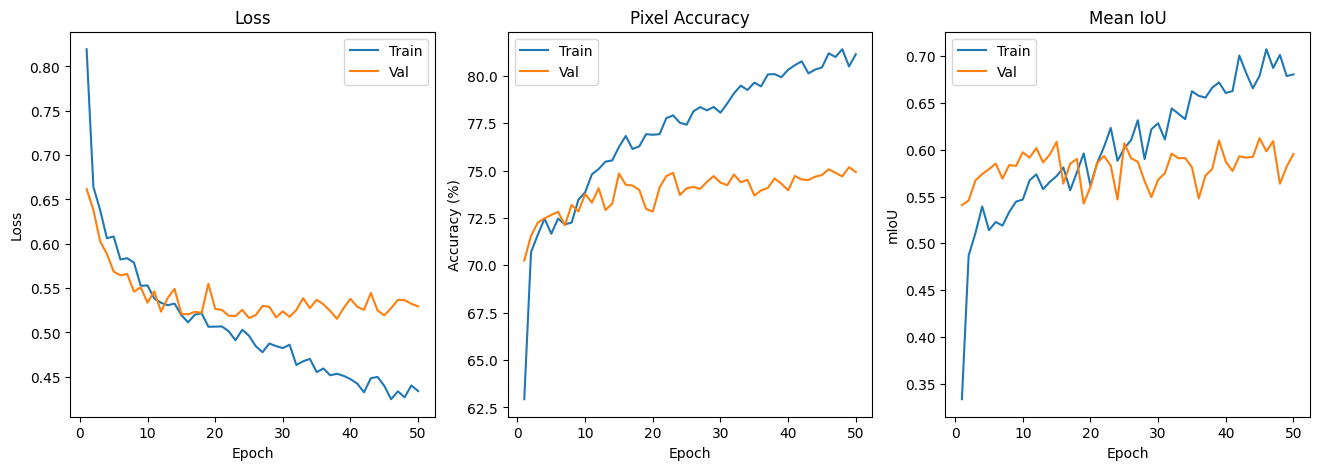

In [22]:
epochs = range(1, num_epochs+1)
plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
plt.plot(epochs, train_losses, label="Train")
plt.plot(epochs, val_losses, label="Val")
plt.title("Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

plt.subplot(1,3,2)
plt.plot(epochs, [a*100 for a in train_accs], label="Train")
plt.plot(epochs, [a*100 for a in val_accs], label="Val")
plt.title("Pixel Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.legend()

plt.subplot(1,3,3)
plt.plot(epochs, train_ious, label="Train")
plt.plot(epochs, val_ious, label="Val")
plt.title("Mean IoU"); plt.xlabel("Epoch"); plt.ylabel("mIoU"); plt.legend()

plt.show()


Calling the trained model

In [ ]:
# from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor

# # Path where you saved earlier
# load_dir = "/content/drive/MyDrive/segformer_lulc"

# # Load trained model + processor
# model = SegformerForSemanticSegmentation.from_pretrained(load_dir)
# processor = SegformerFeatureExtractor.from_pretrained(load_dir)

# print("✅ Trained model and processor loaded successfully!")


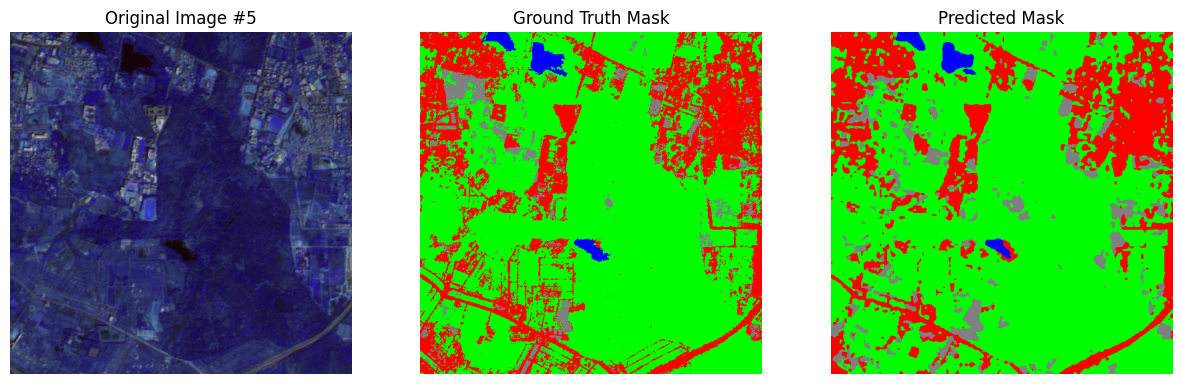

In [27]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch

# Color map for 5 classes
COLOR_MAP = {
    0: (255, 255,   0),   # Barren -> Yellow
    1: (255,   0,   0),   # Urban  -> Red
    2: (  0,   0, 255),   # Water  -> Blue
    3: (  0, 255,   0),   # Vegetation -> Green
    4: (128, 128, 128)    # Others -> Gray
}

def decode_color(mask_np):
    """Map class indices to RGB colors for visualization"""
    h, w = mask_np.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for cls, color in COLOR_MAP.items():
        rgb[mask_np == cls] = color
    return rgb

# -------------------------------
# Inference for a specific index
# -------------------------------
model.eval()
idx = 5   # <-- choose any index here

# Make sure dataset returns correct pair
img, true_mask = val_dataset[idx]   # img: [3,512,512], true_mask: [512,512]
img_batch = img.unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(pixel_values=img_batch)
    pred_mask = torch.argmax(outputs, dim=1).squeeze(0).cpu().numpy()  # Changed outputs.logits to outputs

# Convert tensors back for visualization
true_mask = true_mask.cpu().numpy()
img_vis = img.cpu().numpy()

# Undo normalization for display
mean = np.array([0.485, 0.456, 0.406]).reshape(3,1,1)
std  = np.array([0.229, 0.224, 0.225]).reshape(3,1,1)
img_vis = (img_vis * std + mean).clip(0,1)
img_vis = np.transpose(img_vis, (1,2,0))  # CHW -> HWC

# -------------------------------
# Show results
# -------------------------------
plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(img_vis); plt.title(f"Original Image #{idx}"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(decode_color(true_mask)); plt.title("Ground Truth Mask"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(decode_color(pred_mask)); plt.title("Predicted Mask"); plt.axis("off")
plt.show()

In [25]:
save_dir = "/content/drive/MyDrive/2.1_CustomB2_CE+Lovasz_lulc"

import os
import torch
os.makedirs(save_dir, exist_ok=True)

# Save trained model state dictionary
torch.save(model.state_dict(), os.path.join(save_dir, 'model_state_dict.pth'))

# The custom model doesn't have a save_pretrained method for the processor.
# If you were using the Hugging Face SegformerForSemanticSegmentation, you would save the processor like this:
# processor.save_pretrained(save_dir)

print(f"✅ Model state dictionary saved to {os.path.join(save_dir, 'model_state_dict.pth')}")

✅ Model state dictionary saved to /content/drive/MyDrive/2.1_CustomB2_CE+Lovasz_lulc/model_state_dict.pth
